In [18]:
import numpy as np
from scipy.signal import hilbert, butter, filtfilt
import matplotlib.pyplot as plt

In [62]:
def load_data(filename):
    with open(filename, 'r', encoding='utf-8') as file:
        lines = file.readlines()
    split_data = [line.strip().split('\t') for line in lines]
    data = list(zip(*split_data))
    data_float = [[float(value) for value in column] for column in data]

    return data_float


In [66]:
data_pd = load_data('test_pd_lfp_data.txt')
data_ctl = load_data('test_control_lfp_data.txt')

In [67]:
data_ctx_pd = data_pd[:2]
data_str_pd = data_pd[2:4]
data_ctx_ctl = data_ctl[:2]
data_str_ctl = data_ctl[2:4]
test_pd = list(data_str_pd[0])[2000:12000]
test_ctl = list(data_str_ctl[0])[2000:12000]


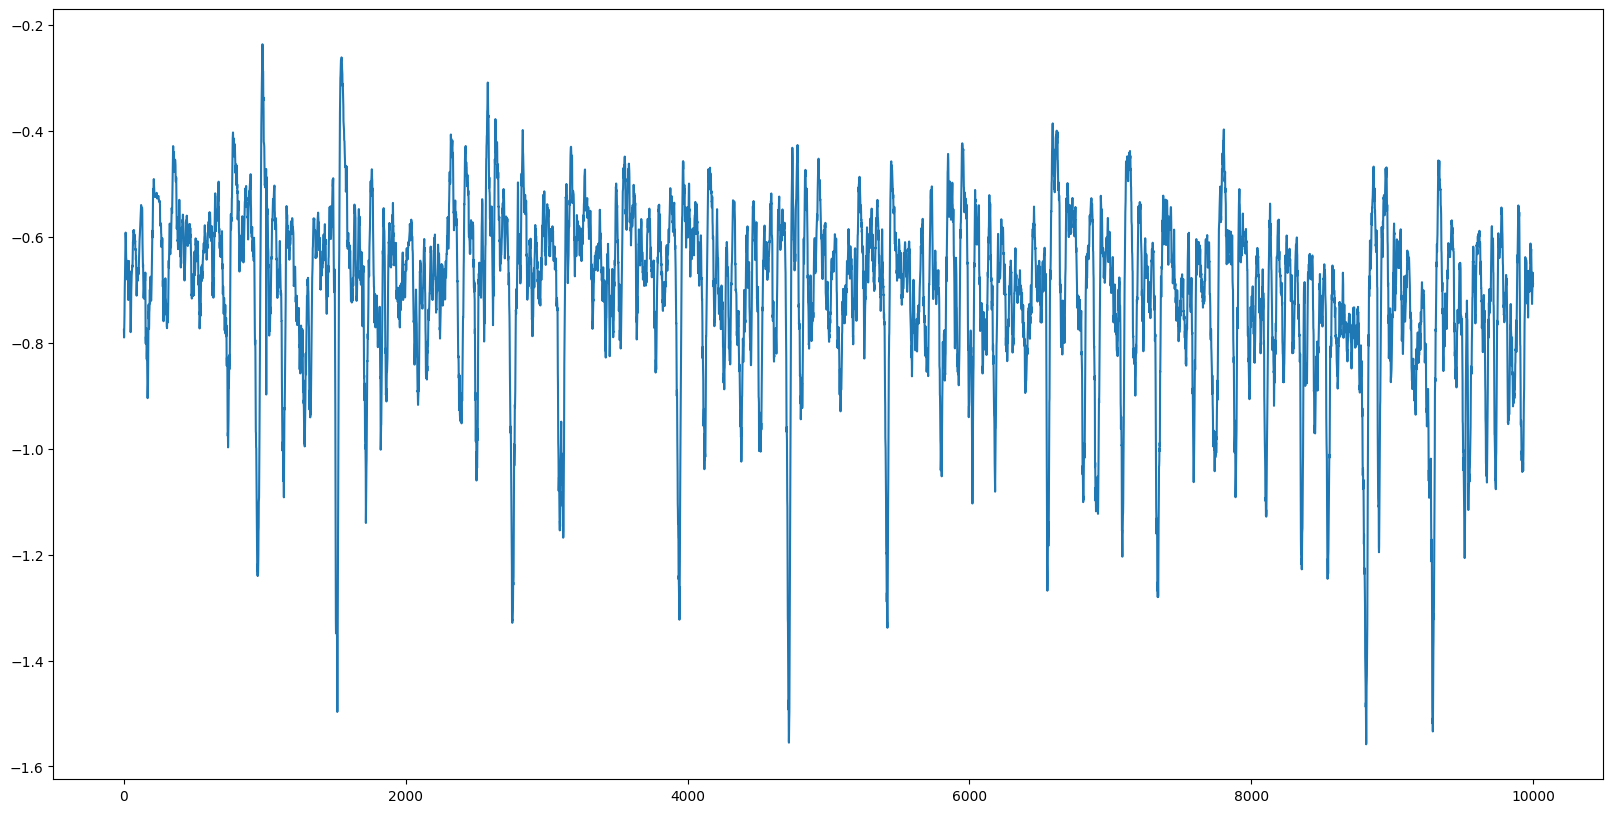

In [71]:
plt.figure(figsize=(20,10))
plt.plot(test_ctl)

In [72]:
from scipy.fft import fft, fftfreq
import scipy.signal as signal
def compute_psd_fft(data,fs,start_freq,end_freq):
    N = 10000
    T = 1/fs
    fft_y = fft(data)
    power_spectrum = (np.abs(fft_y) ** 2)[:N//2]
    xf = fftfreq(N, T)[:N//2]
    psd_norm = power_spectrum / (N * fs)#normalize
    psd_db = 10 * np.log10(psd_norm)

    return psd_norm[start_freq:end_freq+1],xf[start_freq:end_freq+1]

def compute_psd_welch(data,fs,start_freq,end_freq):
    frequencies, psd = signal.welch(data, fs=fs, nperseg=2000)
    return psd[start_freq*2:end_freq*2+1],frequencies[start_freq*2:end_freq*2+1]


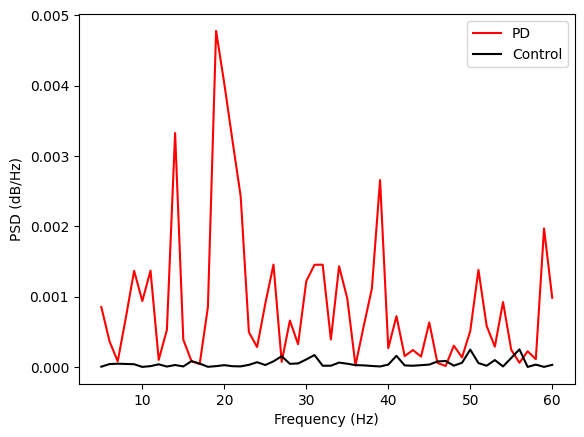

In [78]:
power_spectrum_ctl,xf = compute_psd_fft(test_ctl,10000,start_freq=5,end_freq=60)
power_spectrum_pd,xf = compute_psd_fft(test_pd,10000,start_freq=5,end_freq=60)

plt.plot(xf,power_spectrum_pd,label='PD',color='red')
plt.plot(xf,power_spectrum_ctl,label='Control',color='k')
#plt.plot(xf,np.mean(np.array(psd_pdr),axis=0),label='No DA+Glu Inh',color='blue')
#plt.plot(xf,np.mean(np.array(psd_glu),axis=0),label='Control+Glu Exc',color='green')
plt.xlabel('Frequency (Hz)')
plt.ylabel('PSD (dB/Hz)')
plt.legend()
plt.show()


In [55]:
xf

array([ 100.,  105.,  110.,  115.,  120.,  125.,  130.,  135.,  140.,
        145.,  150.,  155.,  160.,  165.,  170.,  175.,  180.,  185.,
        190.,  195.,  200.,  205.,  210.,  215.,  220.,  225.,  230.,
        235.,  240.,  245.,  250.,  255.,  260.,  265.,  270.,  275.,
        280.,  285.,  290.,  295.,  300.,  305.,  310.,  315.,  320.,
        325.,  330.,  335.,  340.,  345.,  350.,  355.,  360.,  365.,
        370.,  375.,  380.,  385.,  390.,  395.,  400.,  405.,  410.,
        415.,  420.,  425.,  430.,  435.,  440.,  445.,  450.,  455.,
        460.,  465.,  470.,  475.,  480.,  485.,  490.,  495.,  500.,
        505.,  510.,  515.,  520.,  525.,  530.,  535.,  540.,  545.,
        550.,  555.,  560.,  565.,  570.,  575.,  580.,  585.,  590.,
        595.,  600.,  605.,  610.,  615.,  620.,  625.,  630.,  635.,
        640.,  645.,  650.,  655.,  660.,  665.,  670.,  675.,  680.,
        685.,  690.,  695.,  700.,  705.,  710.,  715.,  720.,  725.,
        730.,  735.,

In [46]:
def signal_filt(data, fs, lowcut, highcut):
    nyquist = 0.5 * fs
    low = lowcut / nyquist
    high = highcut / nyquist
    b, a = butter(2, [low, high], btype='band')
    filtered_data = filtfilt(b, a, data)
    return filtered_data


def mod_index_v2(phase, amp, position):
    """
    Compute the modulation index and mean amplitude distribution.

    Parameters:
    phase (array-like): Phase time series
    amp (array-like): Amplitude time series
    position (array-like): Phase bins (left boundary)

    Returns:
    MI (float): Modulation index
    mean_amp (numpy.ndarray): Amplitude distribution over phase bins (non-normalized)
    """
    nbin = len(position)
    winsize = 2 * np.pi / nbin

    # Compute the mean amplitude in each phase bin
    mean_amp = np.zeros(nbin)
    for j in range(nbin):
        I = np.where((phase < position[j] + winsize) & (phase >= position[j]))[0]
        mean_amp[j] = np.mean(amp[I])

    # Calculate the modulation index using normalized entropy
    p = mean_amp / np.sum(mean_amp)
    entropy = -np.sum(p * np.log(p))
    MI = (np.log(nbin) - entropy) / np.log(nbin)

    return MI, mean_amp


In [47]:
def cal_mi(lfp_amp, lfp_pha, PhaseFreqVector, AmpFreqVector, PhaseFreq_BandWidth, AmpFreq_BandWidth, fs):
    # Define phase bins
    data_length = len(lfp_amp)
    nbin = 18  # number of phase bins
    position = np.zeros(nbin)  # this variable will get the beginning (not the center) of each phase bin (in rads)
    winsize = 2 * np.pi / nbin
    for j in range(nbin):
        position[j] = -np.pi + j * winsize

    # Filtering and Hilbert transform
    Comodulogram = np.zeros((len(PhaseFreqVector), len(AmpFreqVector)), dtype=np.float32)
    AmpFreqTransformed = np.zeros((len(AmpFreqVector), data_length))
    PhaseFreqTransformed = np.zeros((len(PhaseFreqVector), data_length))

    # Amplitude filtering and Hilbert transform
    for ii, Af1 in enumerate(AmpFreqVector):
        Af2 = Af1 + AmpFreq_BandWidth
        AmpFreq = signal_filt(lfp_amp, fs, Af1, Af2)
        AmpFreqTransformed[ii, :] = np.abs(hilbert(AmpFreq))

    # Phase filtering and Hilbert transform
    for jj, Pf1 in enumerate(PhaseFreqVector):
        Pf2 = Pf1 + PhaseFreq_BandWidth
        PhaseFreq = signal_filt(lfp_pha, fs, Pf1, Pf2)
        PhaseFreqTransformed[jj, :] = np.angle(hilbert(PhaseFreq))
     
    # Initialize Comodulogram matrix
    Comodulogram = np.zeros((len(PhaseFreqVector), len(AmpFreqVector)))

    # Comodulation loop
    for ii in range(len(PhaseFreqVector)):
        for jj in range(len(AmpFreqVector)):
            MI, MeanAmp = mod_index_v2(PhaseFreqTransformed[ii, :], AmpFreqTransformed[jj, :], position)
            Comodulogram[ii, jj] = MI

    # Handle NaN values by replacing them with the minimum value in the Comodulogram
    #fill_value = np.nanmin(Comodulogram)
    #Comodulogram = np.nan_to_num(Comodulogram, nan=fill_value)

    return Comodulogram

        

In [48]:
PhaseFreqVector=np.arange(22,2,50)
AmpFreqVector= np.arange(50,5,200)

PhaseFreq_BandWidth=2
AmpFreq_BandWidth=10

fs = 10000

cal_mi(data_ctx, data_str, PhaseFreqVector, AmpFreqVector, PhaseFreq_BandWidth, AmpFreq_BandWidth, fs)

array([], shape=(0, 0), dtype=float64)